<a href="https://colab.research.google.com/github/HerraKaava/tensorflow/blob/main/CNNs/introduction_to_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to computer vision</h1>

Computer vision is the practice of writing algorithms that can discover patterns in visual data. One example is the camera of a self-driving car, which recognizes the cars in front of it.

<br>

In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pathlib
import glob
import random

In [ ]:
print(tf.__version__)

2.15.0


<h3>Load in the data</h3>

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/datasets/dansbecker/food-101

<br>

However, we've modified it to only use two classes; pizza and steak. We start with a smaller dataset so we can experiment quickly and figure out what works (or better yet, what doesn't work) before moving onto the larger dataset. Ultimately, we want our classifier to be able to tell whether images of food are pizza or steak (or neither one of them).

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-07-19 11:59:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.7.59, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   175MB/s    in 0.6s    

2024-07-19 11:59:07 (175 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



<h3>Exploring the dataset</h3>

In [ ]:
# Looking inside the pizza_steak folder
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train

pizza  steak


In [ ]:
!ls pizza_steak/test

pizza  steak


In [ ]:
!ls pizza_steak/train/pizza

1008104.jpg  1572608.jpg  2097315.jpg  2572958.jpg  3084957.jpg  3693710.jpg  668944.jpg
1008144.jpg  1573562.jpg  2098014.jpg  2574896.jpg  3102271.jpg  3699992.jpg  670201.jpg
1008844.jpg  1576248.jpg  2104569.jpg  2576168.jpg  3105724.jpg  3702863.jpg  674188.jpg
1008941.jpg  1577871.jpg  2110257.jpg  2577373.jpg  3109486.jpg  3703769.jpg  676432.jpg
1011404.jpg  1584379.jpg  2112757.jpg  2577377.jpg  312479.jpg	 3704879.jpg  682201.jpg
102037.jpg   1593665.jpg  2121603.jpg  2581276.jpg  3128495.jpg  3705479.jpg  68684.jpg
1026922.jpg  1593835.jpg  2126352.jpg  2584745.jpg  3148119.jpg  370643.jpg   698251.jpg
1029698.jpg  1600705.jpg  2126709.jpg  2587918.jpg  3164761.jpg  3712344.jpg  702165.jpg
1033251.jpg  1608000.jpg  2135635.jpg  2587921.jpg  3168266.jpg  3713343.jpg  704161.jpg
1035854.jpg  1617418.jpg  2137341.jpg  259449.jpg   3170114.jpg  372275.jpg   709273.jpg
1038357.jpg  1620560.jpg  2142812.jpg  2602611.jpg  3173779.jpg  3742272.jpg  709947.jpg
1040878.jpg  1620761.jp

- Looks like the train folder contains a lot of images.

In [ ]:
for dir_path, dir_names, file_names in os.walk("/content/pizza_steak"):
    if len(file_names) != 0:
        print(f"There are {len(file_names)} images in {dir_path}")

There are 750 images in /content/pizza_steak/train/pizza
There are 750 images in /content/pizza_steak/train/steak
There are 250 images in /content/pizza_steak/test/pizza
There are 250 images in /content/pizza_steak/test/steak


In [55]:
# Class names
data_dir = pathlib.Path("/content/pizza_steak/train")
class_names = [item.name for item in data_dir.glob(pattern="*")]

- "*" is a wildcar symbol, which means that any letters are accepted.

In [56]:
class_names

['pizza', 'steak']

In [99]:
# Visualize images
def view_random_img(img_dir, img_class):
    """
    Picks a random image from a given folder of a given class.

    Args:
    img_dir -- directory where the images are located
    img_class -- class of the img that you wish to visualize

    Returns:
    img -- a random image
    """
    img_folder = img_dir + img_class
    img_names_list = os.listdir(img_folder)

    # This returns a list, with one element, so we need to index the element out
    random_image = random.sample(population=img_names_list, k=1)

    # Read in the image using matplotlib.image
    img = mpimg.imread(fname=img_folder + "/" + random_image[0])

    # Print the shape of the image
    print(f"Shape of the image: {img.shape}")
    print()

    # Plot the iamge
    plt.figure(figsize=(6,4), dpi=150)
    plt.title(img_class, size=12)
    plt.axis("off")
    plt.imshow(img);

    return img

Shape of the image: (512, 512, 3)



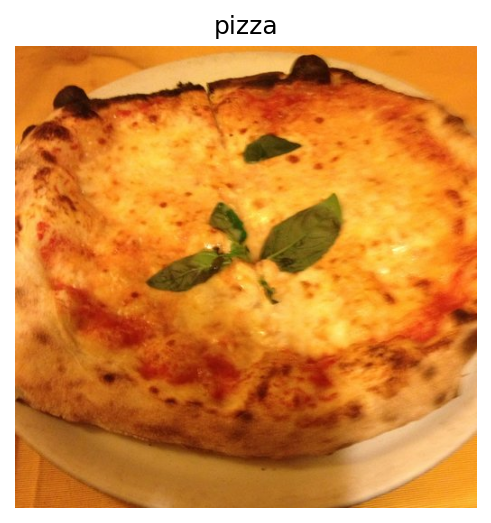

In [120]:
img = view_random_img("/content/pizza_steak/test/", "pizza")

In [121]:
img.shape

(512, 512, 3)

In [122]:
img.dtype

dtype('uint8')

In [123]:
img[:3, :3, :]

array([[[213, 112,  22],
        [210, 109,  19],
        [208, 107,  17]],

       [[213, 112,  22],
        [212, 111,  21],
        [212, 111,  21]],

       [[211, 110,  20],
        [212, 111,  21],
        [213, 112,  22]]], dtype=uint8)

- Inputs to the neural network will be these kinds of tensors, where the elements represents pixels of the image: (pixel_width, pixel_height, num_color_channels).
- The images are usually collapsed such that one image represents a column vector: $(\text{pixel_width} \, * \, \text{pixel_height} \, * \, \text{num_color_channels}, 1)$

In [126]:
# Collapse the image (tensor) into a column vector
reshaped_img = img.reshape(-1, 1)

In [127]:
reshaped_img.shae

(786432, 1)

In [132]:
from operator import imatmul
# NNs tend to perform better with normalized data
# Let's normalize our image to have values between 0 and 1
# To do this, divide all of the elements by the max value
max_val = float(np.max(reshaped_img))
img_reshaped_scaled = reshaped_img / max_val

In [134]:
print(f"Maximum value of reshaped_img: {max_val}")
print(np.max(img_reshaped_scaled))
print(np.min(img_reshaped_scaled))

Maximum value of reshaped_img: 255.0
1.0
0.0


- Bravo.